In [102]:
#!~/.conda/envs/lra/bin/python3
import os
import sys
import re
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from collections import defaultdict 
import numpy as np
# import UnionFind
import edlib
import multiprocessing 
import colorcet as cc
import random

In [103]:
input_path = "/project/mchaisso_100/cmb-16/jingwenr/trfCall/revision/special_loci"
delta_threshold= ["original", "q-0.1", "q-0.2"]

assemblies = [file for file in os.listdir("/project/mchaisso_100/cmb-16/jingwenr/trfCall/revision/special_loci/anno_combined_subject10/original") \
              if file.endswith(".anno.vcf") and "_h" in file ]
assemblies = sorted(assemblies)
VNTRs = ["ABCA7"]

In [104]:
len(assemblies)

166

In [132]:
class Allele:
    def __init__ (self, VNTR_locus):
        self.vntr2anno = defaultdict(lambda: defaultdict(lambda: defaultdict(list))) # vntr -> delta -> assembly -> annos
        self.vntr_space = defaultdict(lambda: defaultdict(int)) # vntr -> delta -> 0 / 1 means: the color space 
        
        # read in original motif
        self.original_motif_map = defaultdict(lambda: defaultdict(int)) # vntr -> original motif -> index
        omotif_file = f"{input_path}/{VNTR_locus}/original/vntr_motif.bed"
        with open(omotif_file, 'r') as f:
            lines = f.readlines()
            for idx, line in enumerate(lines):
                fields = re.split('\t', line.strip('\n'))
                chrm = fields[0]
                start = fields[1]
                end = fields[2]
                motifs = re.split(",", fields[3])
                vntr = chrm + ":" + start + "-" + end
                cnt = 0
                for motif in motifs:
                    self.original_motif_map[vntr][motif] = cnt
                    cnt += 1
                    
        self.readVcfAnnotation(VNTR_locus) 
        self.appendLength()
        self.plot_path = f"{input_path}/plot/{VNTR_locus}" 
        

    def readVcfAnnotation (self, VNTR_locus):
        """
        read the assembly vcf annotations
        """
        for asm in assemblies:
#             if asm.startswith("HG00733") or asm.startswith("NA19240") or asm.startswith("HG00514"): continue
            for delta in delta_threshold:
                
                file = f"{input_path}/{VNTR_locus}/{delta}/{asm}"
                with open(file, 'r') as f:
                    lines = f.readlines()
                    for idx, line in enumerate(lines):
                        if line.startswith("#"):
                            continue
                        fields = re.split('\t', line.strip('\n'))
                        chrm = fields[0]
                        start = fields[1]
                        infos = re.split(";", fields[7])
                        end = re.split("=", infos[0])[1]
                        anno = re.split("=", infos[3])[1]
                        p_anno = [int(motif) for motif in re.split(",", anno)]
                        emotifs = re.split("=", infos[1])[1]
                        p_emotifs = re.split(",",emotifs)
                        vntr = chrm + ":" + start + "-" + end
                        self.vntr2anno[vntr][delta][asm] = [self.original_motif_map[vntr][p_emotifs[idx]] for idx in p_anno]
#                         self.vntr2anno[vntr][delta][asm] = p_anno

#         for vntr in self.vntr2anno:
#             for delta in self.vntr2anno[vntr]:
#                 self.vntr2anno[vntr][delta] = {k: v for k, v in sorted(self.vntr2anno[vntr][delta].items(), key=lambda item: len(item[1]), reverse=True)}


    def appendLength(self):
        """
        make annotation the same length per VNTR
        """
        for vntr in self.vntr2anno.keys():
            for delta in self.vntr2anno[vntr].keys():
                self.vntr_space[vntr][delta] = 0
                max_length = 0
                max_motif = -1
                for asm in self.vntr2anno[vntr][delta].keys():
                    max_length = max(max_length, len(self.vntr2anno[vntr][delta][asm]))
                    max_motif = max(max_motif, max(self.vntr2anno[vntr][delta][asm]))
                max_length += 1
                max_motif += 1

                for asm in self.vntr2anno[vntr][delta].keys():
                    if len(self.vntr2anno[vntr][delta][asm]) < max_length:
                        self.vntr2anno[vntr][delta][asm].extend([480] * (max_length - len(self.vntr2anno[vntr][delta][asm])))   
                        self.vntr_space[vntr][delta] = 1                    

                    
    """
    heatmap for one VNTR
    """
    def heatmap(self, vntr, delta):
#         print(self.vntr2anno)
        asms = list(self.vntr2anno[vntr][delta].keys())
        data_anno = [self.vntr2anno[vntr][delta][asm] for asm in asms]
        np_annp = np.array(data_anno)
        max_motif = max([max(self.vntr2anno[vntr][delta][asm]) for asm in asms])
        cmap = sns.color_palette(cc.glasbey_light, max_motif - 1)
        cmap.append((1,1,1)) 


        print(max_motif, len(cmap))
        # the index of the position of yticks
        num_ticks = len(asms)
        yticks = np.linspace(0, len(asms) - 1, num_ticks, dtype=np.int)
        yticklabels = [asms[idx] for idx in yticks]
        

        plt.figure(figsize=(12, 8))
#         ax = sns.heatmap(np_annp, cmap=cmap)
        ax = sns.heatmap(np_annp, cmap=cmap, yticklabels=yticklabels)
        ax.set_yticklabels(yticklabels, rotation=0, fontsize="5")
        if delta.startswith('q'):
            tmp = delta.split('-')[1]
            plt.title(f"q = {tmp}", fontsize=22)
        else:
            plt.title(f"q = 0 (no compression)", fontsize=22)
        plt.savefig(self.plot_path + "/allele.q_" + delta + ".pdf", dpi=300, format="pdf")
        plt.show()
        plt.close()


480 480


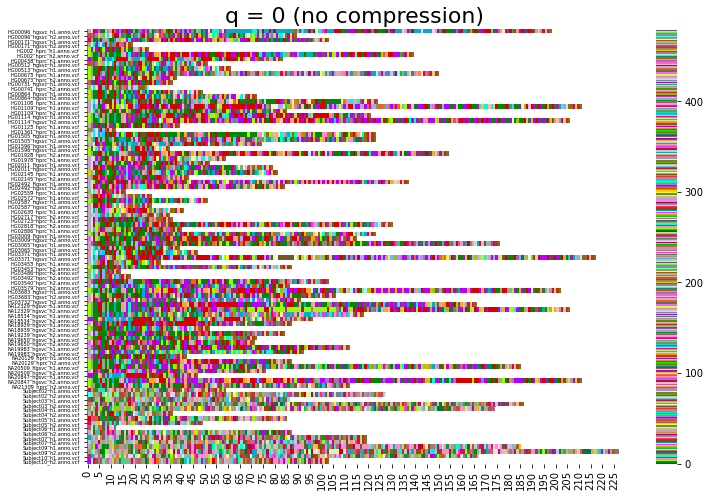

480 480


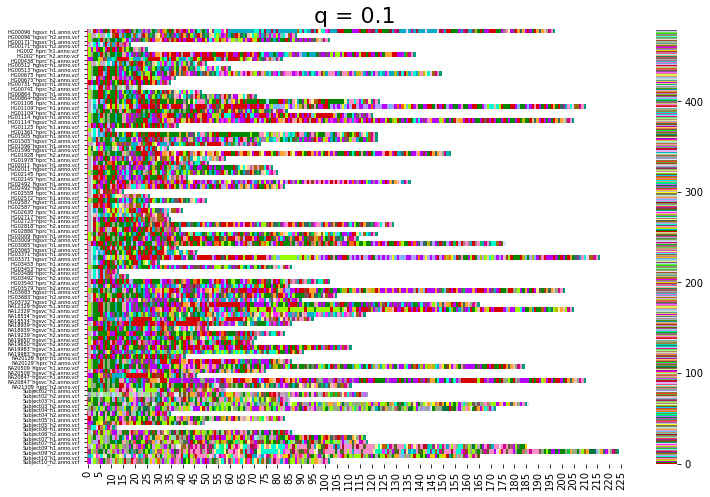

480 480


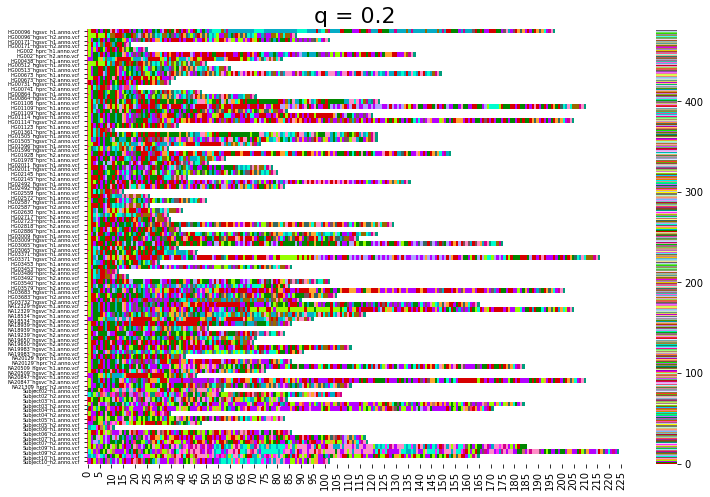

In [133]:
VNTR_locus = VNTRs[0]
allele = Allele(VNTR_locus)
vntrs = list(allele.vntr2anno.keys())
vntrs.sort()
for vntr in vntrs:
    for delta in allele.vntr2anno[vntr].keys():
        allele.heatmap(vntr, delta)

In [127]:
allele_length = {'asm': [], 'compression': [], 'length': [], 'group': []}
vntr = 'chr19:1049437-1050066'
for compression in ['original']:
    for asm in assemblies:
        length = len(allele.vntr2anno[vntr][compression][asm])
        allele_length['asm'].append(asm) 
        allele_length['compression'].append(compression)
        allele_length['length'].append(length) 
        if 'Sub' in asm:
            allele_length['group'].append('disease')
        else:
            allele_length['group'].append('normal')
    

In [128]:
df = pd.DataFrame.from_dict(allele_length)

In [129]:
df

,asm,compression,length,group
0,HG00096_hgsvc_h1.anno.vcf,original,229,normal
1,HG00096_hgsvc_h2.anno.vcf,original,229,normal
2,HG00171_hgsvc_h1.anno.vcf,original,229,normal
3,HG00171_hgsvc_h2.anno.vcf,original,229,normal
4,HG002_hprc_h1.anno.vcf,original,229,normal
...,...,...,...,...
161,Subject08_h2.anno.vcf,original,0,disease
162,Subject09_h1.anno.vcf,original,229,disease
163,Subject09_h2.anno.vcf,original,229,disease
164,Subject10_h1.anno.vcf,original,229,disease


In [ ]:
df['length'].hist(by=df['group'])